In [ ]:
import torch
import pytorch3d
from pytorch3d.structures import Pointclouds

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.renderer.mesh.shading import (
    _apply_lighting,
)

# rendering components
from pytorch3d.renderer import (
    FoVOrthographicCameras, 
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    SoftPhongShader,
)


from src.ShadingPointsRenderer import (
    ShadingCompositor,
    ShadingPointsRenderer,
)

In [ ]:
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj

# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ =  load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
textures =  TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)
teapot_mesh

In [ ]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

R, T = look_at_view_transform(100, 100, 10000)

# Select the viewpoint using spherical angles
distance = 3 # Distance from camera to the object
elevation = 50. # angle of elevation in degrees
azimuth = 0.0 # No rotation so the camera is positioned on the +Z axis

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
#R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
cameras

In [13]:
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    look_at_view_transform,
    PointLights,
    PointsRasterizer,
    PointsRasterizationSettings,
)

from src.ShadingPointsRenderer import (
    ShadingCompositor,
    ShadingPointsRenderer,
)

class Renderer():
    def __init__(self, device, viewpoint, lights, raster):        
       
    
    def to(self, device):
        new_self = super(Renderer, self).to(device)
        new_self._train_noise = new_self._train_noise.to(device)
        new_self._eval_noise = new_self._eval_noise.to(device)
        
        R, T = look_at_view_transform(
            self.opt.viewpoint_distance, 
            self.opt.viewpoint_elevation, 
            self.opt.viewpoint.azimuth, 
            device=device)
        cameras = FoVPerspectiveCameras(
            device=device, R=R, T=T)
        raster_settings = PointsRasterizationSettings(
            image_size= self.opt.raster_image_size, 
            radius = self.opt.raster_radius,
            points_per_pixel = self.opt.raster_points_per_pixel,
        )
        rasterizer = PointsRasterizer(
            cameras= cameras, 
            raster_settings=raster_settings
        )
        lights = PointLights(device=device, 
                             location=[self.opt.lights_location])
        compositor = ShadingCompositor(
            device=device, 
            cameras=cameras,
            lights=lights
        )        
        new_self.renderer = ShadingPointsRenderer(
            rasterizer=rasterizer,
            compositor=compositor,
        ) 

        return new_self

    def __call__(self, point_cloud):
        return self.renderer(point_cloud)
        

In [ ]:
import torch

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

In [6]:
import torch
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer import TexturesVertex


# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)



# Load the obj and ignore the textures and materials.
verts, faces_idx, _ =  load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
textures =  TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)


n_points = 1000000
vertices, normals = sample_points_from_meshes(teapot_mesh, 
    n_points, return_normals=True)

vertices =  vertices[0].to(device)
normals =  normals[0].to(device)

rgb = torch.ones((n_points, 4), device=device) - 0.3

point_cloud = Pointclouds(points=[vertices], 
                          normals=[normals],
                          features=[rgb],)

In [14]:
from argparse import Namespace

# Select the viewpoint using spherical angles
distance = 2 # Distance from camera to the objectlights = PointLights(device=device, location=[[0.0, -1.0, 3.0]])
elevation = 0. # angle of elevation in degrees
azimuth = 0.0 # No rotation so the camera is positioned on the +Z axis
viewpoint = Namespace(distance=distance, 
                      elevation=elevation, 
                      azimuth=azimuth)

lights =  Namespace(location=[[0.0, -1.0, 3.0]])

raster =  Namespace(image_size=512, 
                    radius=0.003,
                    points_per_pixel=4)

renderer = Renderer(device, viewpoint, lights, raster)
renderer

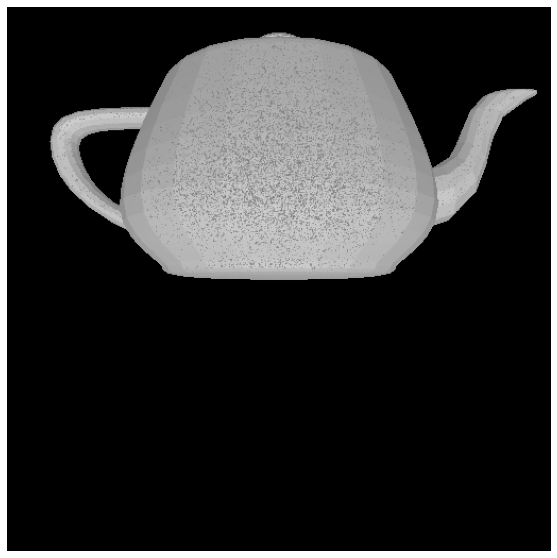

In [16]:
import matplotlib.pyplot as plt

images =  renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");